# Importing necessary things

In [1]:
import pandas as pd
import numpy as np
import sklearn

import sklearn.metrics as metrics
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

from collections import Counter

import re
from datetime import datetime

import pickle

import string

==================================================================================================================

# EDA

In [2]:
# Retrieving the list.

import bz2

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [3]:
reviewlist = decompress_pickle('compressedlistreview.pbz2')
len(reviewlist)

6470

In [4]:
df = pd.DataFrame(reviewlist)
#df

In [5]:
#Changing datatype to correct datatype

df.dtypes

content                 object
score                   object
thumbsUpCount           object
reviewCreatedVersion    object
at                      object
replyContent            object
appId                   object
dtype: object

In [6]:
df['content'] = df['content'].astype('string')
df['score'] = df['score'].astype('int')
df['thumbsUpCount'] = df['thumbsUpCount'].astype('int')
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].astype('string')
df['at'] = df['at'].astype('string')
df['replyContent'] = df['replyContent'].astype('string')
df['appId'] = df['appId'].astype('string')
df.dtypes

content                 string
score                    int64
thumbsUpCount            int64
reviewCreatedVersion    string
at                      string
replyContent            string
appId                   string
dtype: object

In [7]:
# checking for null values.

df.isna().sum()

content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
appId                   0
dtype: int64

In [8]:
df['score'].value_counts()

5    3082
1    1767
4     649
3     565
2     407
Name: score, dtype: int64

In [9]:
scorecount = Counter(df['score'])
scorecount.most_common(5)

[(5, 3082), (1, 1767), (4, 649), (3, 565), (2, 407)]

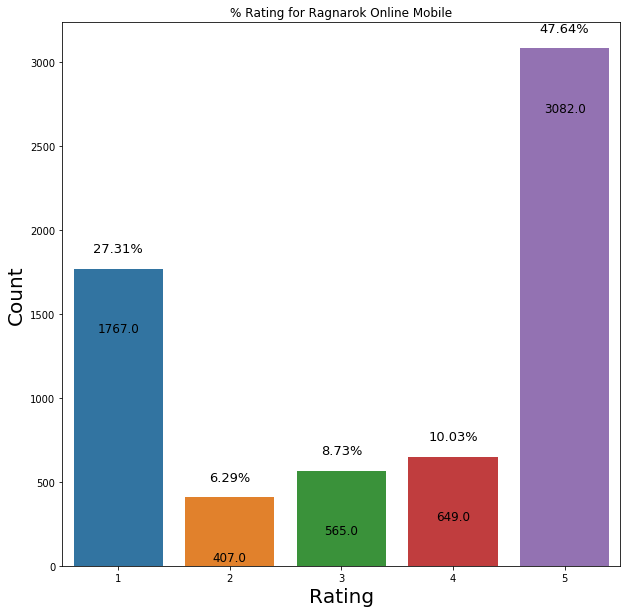

In [10]:
# Plotting distribution of ratings out of all the reviews
# Interestingly, it is very similar to overall rating distribution across all top mobile games.


xaxis = [val[0] for val in scorecount.most_common(5)]
yaxis = [val[1] for val in scorecount.most_common(5)]

plt.figure(figsize=(10,10))
ax = sns.barplot(xaxis, yaxis)

plt.title('% Rating for Ragnarok Online Mobile')
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Rating', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -60),
                 textcoords='offset points')

In [11]:
df['thumbsUpCount'].value_counts()

0      4684
1       910
2       309
3       127
4        88
       ... 
439       1
101       1
89        1
65        1
137       1
Name: thumbsUpCount, Length: 70, dtype: int64

In [12]:
df['reviewCreatedVersion'].value_counts()

1.0.1    4429
None     1176
1.0.7     216
1.0.5     148
1.1.3     147
1.1.0     133
1.2.0      75
1.2.2      60
1.2.4      51
1.2.6      35
Name: reviewCreatedVersion, dtype: Int64

### Datetime cleaning

In [13]:
df['at'].value_counts()

2019-01-09 18:42:54    2
2019-01-09 12:32:53    2
2019-01-09 19:10:18    2
2019-01-11 21:51:55    2
2019-01-09 12:40:16    2
                      ..
2019-07-08 08:33:47    1
2019-03-24 11:45:57    1
2019-02-24 13:43:10    1
2019-01-21 10:28:14    1
2020-11-04 10:38:04    1
Name: at, Length: 6463, dtype: Int64

In [14]:
df['at'] = df['at'].str[0:10]
df['at'].value_counts()

2019-01-09    715
2019-01-10    408
2019-01-11    264
2019-01-12    197
2019-01-08    167
             ... 
2019-11-08      1
2020-12-03      1
2020-05-05      1
2019-12-27      1
2020-02-04      1
Name: at, Length: 614, dtype: Int64

In [15]:
df['month'] = df['at'].str[5:7]
df['month']

0       01
1       01
2       08
3       08
4       03
        ..
6465    01
6466    11
6467    12
6468    12
6469    12
Name: month, Length: 6470, dtype: string

In [16]:
df['at'] = pd.to_datetime(df['at'], format='%Y-%m-%d')
df['at']

0      2019-01-15
1      2019-01-12
2      2019-08-12
3      2020-08-12
4      2019-03-14
          ...    
6465   2020-01-30
6466   2020-11-28
6467   2020-12-01
6468   2020-12-08
6469   2020-12-11
Name: at, Length: 6470, dtype: datetime64[ns]

In [17]:
reviewtimecounts = df['at'].value_counts().reset_index(name='counts')
reviewtimecounts.columns = ['date', 'counts']
reviewtimecounts

,date,counts
0,2019-01-09,715
1,2019-01-10,408
2,2019-01-11,264
3,2019-01-12,197
4,2019-01-08,167
...,...,...
609,2020-07-09,1
610,2020-11-08,1
611,2020-08-07,1
612,2020-11-09,1


In [18]:
reviewtimecounts = reviewtimecounts.sort_values(by='date')
reviewtimecounts

,date,counts
4,2019-01-08,167
0,2019-01-09,715
1,2019-01-10,408
2,2019-01-11,264
3,2019-01-12,197
...,...,...
598,2020-12-03,1
363,2020-12-08,2
566,2020-12-09,1
300,2020-12-10,3


In [19]:
reviewmonthcount = df['month'].value_counts().reset_index(name='counts')
reviewmonthcount.columns = ['month', 'counts']
reviewmonthcount

,month,counts
0,01,3295
1,02,770
2,03,629
3,04,492
4,05,269
5,06,224
6,07,165
7,09,161
8,08,157
9,10,132


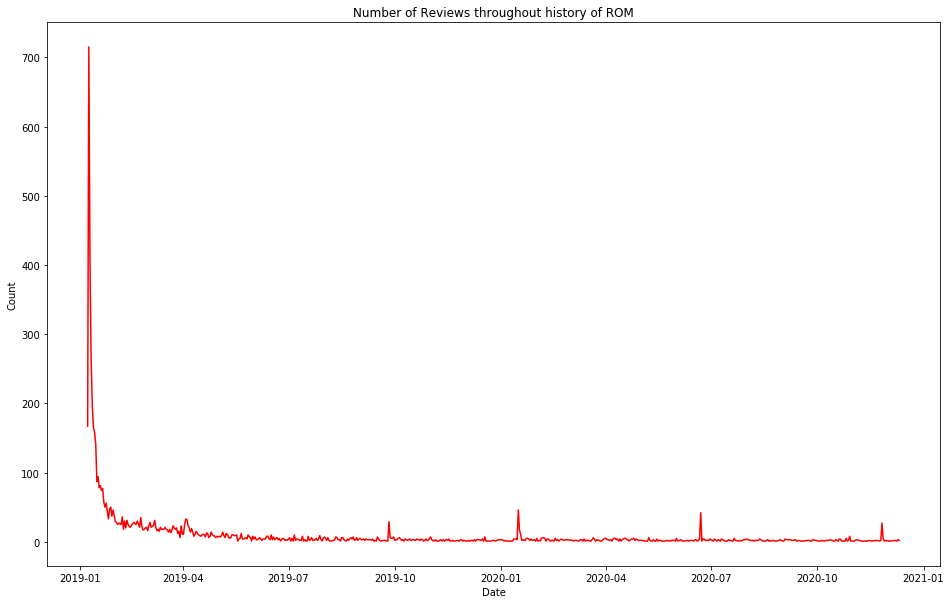

In [20]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(reviewtimecounts['date'],
        reviewtimecounts['counts'],
        color='red')

ax.set(xlabel="Date",
       ylabel="Count",
       title="Number of Reviews throughout history of ROM")

plt.show()

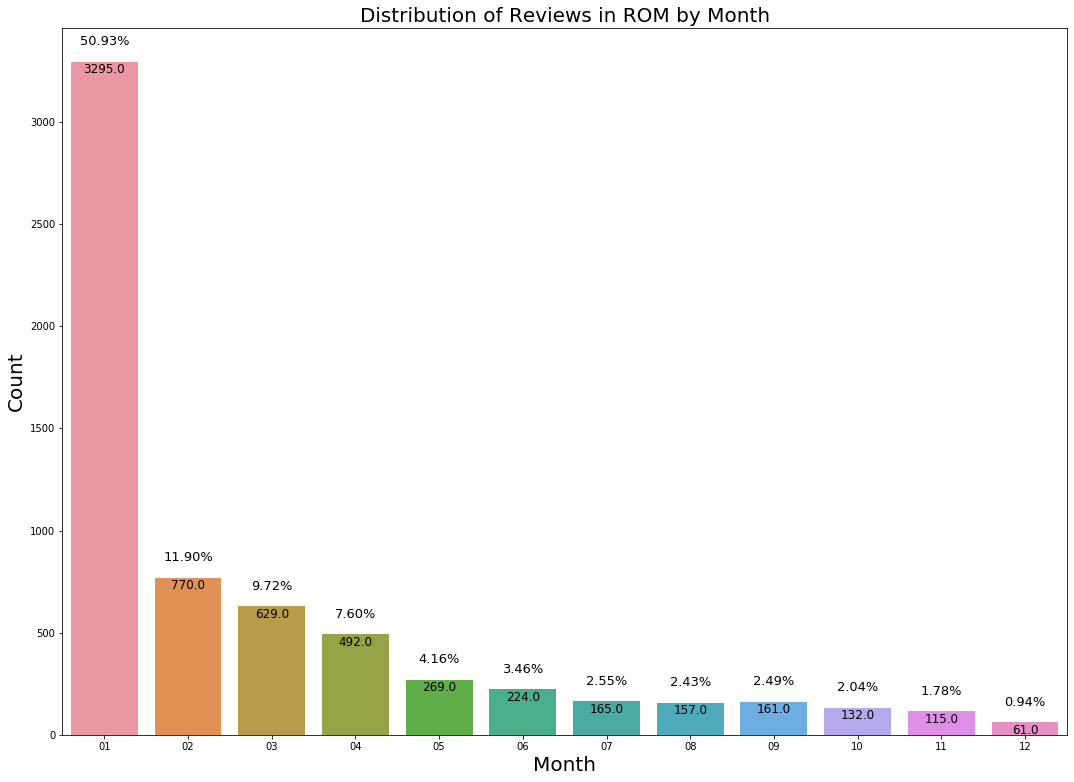

In [21]:
plt.figure(figsize=(18,13))
ax = sns.barplot(reviewmonthcount['month'], reviewmonthcount['counts'])

plt.title('Distribution of Reviews in ROM by Month', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Month', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(reviewmonthcount['counts']))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -8),
                 textcoords='offset points')

## Meta Features

In [23]:
df['content']

0                                             pretty good
1                          oh how I have missed this game
2       Just like the original Ragnarok Online on PC. ...
3                                             Good so far
4                                                 love it
                              ...                        
6465    Umm hellooo can I please atleast try the game ...
6466    This update is awful for emulators. What happe...
6467    Awful. With the recent update, I am unable to ...
6468    This new patch update made the game so laggy, ...
6469                                             Cashgrab
Name: content, Length: 6470, dtype: string

In [24]:
df["numwords"] = df["content"].apply(lambda x: len(str(x).split()))

df["numuniquewords"] = df["content"].apply(lambda x: len(set(str(x).split())))

df["numchars"] = df["content"].apply(lambda x: len(str(x)))

df["numpuncts"] = df['content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df["numcapts"] = df["content"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

df["numtitles"] = df["content"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

df["meanwordlength"] = df["content"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [26]:
df['numwords']

0        2
1        7
2       91
3        3
4        2
        ..
6465    50
6466    79
6467    46
6468    40
6469     1
Name: numwords, Length: 6470, dtype: int64

==================================================================================================================

# Tokenizing

In [ ]:
# Separating reviews into their scores.

rating1 = df.loc[df['score'] == 1]
rating2 = df.loc[df['score'] == 2]
rating3 = df.loc[df['score'] == 3]
rating4 = df.loc[df['score'] == 4]
rating5 = df.loc[df['score'] == 5]

In [ ]:
# Remove common words
stopwords_list = stopwords.words('english') + list(string.punctuation)
# Remove more punctuation
stopwords_list += ["''", '""', '...', '``']
# Remove random numerals
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Remove contractions
stopwords_list += ["'d", "'ve", "ca", "n't",  "'t", "'re", "'ll", "'s"]

In [ ]:
def process_reviews(reviews):
    tokens = nltk.word_tokenize(reviews)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed   

In [ ]:
starttime = datetime.now()

rating1['wordlist'] = rating1['content'].apply(lambda x: process_reviews(x))
rating2['wordlist'] = rating2['content'].apply(lambda x: process_reviews(x))
rating3['wordlist'] = rating3['content'].apply(lambda x: process_reviews(x))
rating4['wordlist'] = rating4['content'].apply(lambda x: process_reviews(x))
rating5['wordlist'] = rating5['content'].apply(lambda x: process_reviews(x))

print(datetime.now() - starttime)

In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [ ]:
starttime = datetime.now()

rating1['wordlistlem'] = rating1['wordlist'].apply(lemmatize_text)
rating2['wordlistlem'] = rating2['wordlist'].apply(lemmatize_text)
rating3['wordlistlem'] = rating3['wordlist'].apply(lemmatize_text)
rating4['wordlistlem'] = rating4['wordlist'].apply(lemmatize_text)
rating5['wordlistlem'] = rating5['wordlist'].apply(lemmatize_text)

print(datetime.now() - starttime)

# Saving Dataframes

In [ ]:
# Saving tokens into a sub-folder in for tidiness.

from pathlib import Path

root = Path('.')

my_path1 = root / "tokens" / "processedreviewrating1.pbz2"
my_path2 = root / "tokens" / "processedreviewrating2.pbz2"
my_path3 = root / "tokens" / "processedreviewrating3.pbz2"
my_path4 = root / "tokens" / "processedreviewrating4.pbz2"
my_path5 = root / "tokens" / "processedreviewrating5.pbz2"

import bz2

def compressed_pickle(path, data):
    with bz2.BZ2File(path, 'w') as f:
        pickle.dump(data, f)

In [ ]:
compressed_pickle(my_path1, rating1)
compressed_pickle(my_path2, rating2)
compressed_pickle(my_path3, rating3)
compressed_pickle(my_path4, rating4)
compressed_pickle(my_path5, rating5)

In [ ]:
# Retrieve our pickled dataframes

rating1 = decompress_pickle(my_path1)
rating2 = decompress_pickle(my_path2)
rating3 = decompress_pickle(my_path3)
rating4 = decompress_pickle(my_path4)
rating5 = decompress_pickle(my_path5)

# Word Frequency in all reviews

In [ ]:
starttime = datetime.now()

processedreviewrating1 = [item for elem in rating1['wordlistlem'] for item in elem]
processedreviewrating2 = [item for elem in rating2['wordlistlem'] for item in elem]
processedreviewrating3 = [item for elem in rating3['wordlistlem'] for item in elem]
processedreviewrating4 = [item for elem in rating4['wordlistlem'] for item in elem]
processedreviewrating5 = [item for elem in rating5['wordlistlem'] for item in elem]

print(datetime.now() - starttime)
print('------------')
print(len(processedreviewrating1))
print(len(processedreviewrating2))
print(len(processedreviewrating3))
print(len(processedreviewrating4))
print(len(processedreviewrating5))

In [ ]:
totalprocessedreviews = processedreviewrating1 + processedreviewrating2 + processedreviewrating3 + processedreviewrating4 + processedreviewrating5
len(totalprocessedreviews)

In [ ]:
review_freqdist = FreqDist(totalprocessedreviews)
review_freqdist.most_common(20)

In [ ]:
mostcommonwords20 = review_freqdist.most_common(20)

yaxis20 = [val[1] for val in mostcommonwords20]

xaxis20 = [val[0] for val in mostcommonwords20]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20, yaxis20)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Top 20 words per Rating [Lemmatized]

In [ ]:
uselesswords = ['game', 'play', 'get', 'still', 'would']
processedreviewrating1[:] = [x for x in processedreviewrating1 if x not in uselesswords]

In [ ]:
review1_freqdist = FreqDist(processedreviewrating1)
review1_freqdist.most_common(20)

In [ ]:
mostcommonwords201 = review1_freqdist.most_common(20)

yaxis201 = [val[1] for val in mostcommonwords201]

xaxis201 = [val[0] for val in mostcommonwords201]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201, yaxis201)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 1', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
processedreviewrating2[:] = [x for x in processedreviewrating2 if x not in uselesswords]

In [ ]:
review2_freqdist = FreqDist(processedreviewrating2)
review2_freqdist.most_common(20)

In [ ]:
mostcommonwords202 = review2_freqdist.most_common(20)

yaxis202 = [val[1] for val in mostcommonwords202]

xaxis202 = [val[0] for val in mostcommonwords202]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis202, yaxis202)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 2', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis202))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
processedreviewrating3[:] = [x for x in processedreviewrating3 if x not in uselesswords]

In [ ]:
review3_freqdist = FreqDist(processedreviewrating3)
review3_freqdist.most_common(20)

In [ ]:
mostcommonwords203 = review3_freqdist.most_common(20)

yaxis203 = [val[1] for val in mostcommonwords203]

xaxis203 = [val[0] for val in mostcommonwords203]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203, yaxis203)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 3', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
processedreviewrating4[:] = [x for x in processedreviewrating4 if x not in uselesswords]

In [ ]:
review4_freqdist = FreqDist(processedreviewrating4)
review4_freqdist.most_common(20)

In [ ]:
mostcommonwords204 = review4_freqdist.most_common(20)

yaxis204 = [val[1] for val in mostcommonwords204]

xaxis204 = [val[0] for val in mostcommonwords204]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis204, yaxis204)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 4', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis204))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
processedreviewrating5[:] = [x for x in processedreviewrating5 if x not in uselesswords]

In [ ]:
review5_freqdist = FreqDist(processedreviewrating5)
review5_freqdist.most_common(20)

In [ ]:
mostcommonwords205 = review5_freqdist.most_common(20)

yaxis205 = [val[1] for val in mostcommonwords205]

xaxis205 = [val[0] for val in mostcommonwords205]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205, yaxis205)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 5', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Bigrams/Trigrams overall

In [ ]:
def n_gramall(df_col, n=None):
    # Build the vectorizer, specify inputted n-gram, remove stop words
    vect = CountVectorizer(ngram_range = (n,n), stop_words = gramstopwords_list, min_df = 10)
    # fit/transform vectorizer on specified column
    vect_fit = vect.fit_transform(df_col.values.astype('U'))
    # get all words and store in a list
    word_list = vect.get_feature_names()
    # get a count of all the words
    count_list = vect_fit.toarray().sum(axis=0)
    #create a dictionary of word to count pairings
    count_dict = dict(zip(word_list, count_list))
    # sort the dictionary to show highest counted words on top
    sort_vocab = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    return sort_vocab

In [ ]:
gramstopwords_list = stopwords.words('english') + list(string.punctuation)
gramstopwords_list += ["''", '""', '...', '``']

In [ ]:
bigramall = n_gramall(df['content'], n=2)
bigramall[:20]

In [ ]:
mostcommonwords20bigram = bigramall[:20]

yaxis20bigram = [val[1] for val in mostcommonwords20bigram]

xaxis20biram = [val[0] for val in mostcommonwords20bigram]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20biram, yaxis20bigram, palette ="rocket_r")
plt.title('Top 20 Most Bigrams in Ragnarok Mobile Reviews Overall', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20bigram))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
trigramall = n_gramall(df['content'], n=3)
trigramall[:20]

In [ ]:
mostcommonwords20trigram = trigramall[:20]

yaxis20trigram = [val[1] for val in mostcommonwords20trigram]

xaxis20triram = [val[0] for val in mostcommonwords20trigram]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20triram, yaxis20trigram, palette ="cubehelix")
plt.title('Top 20 Most Trigrams in Mobile Game Reviews Overall', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20trigram))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Bigrams/Trigrams for specific ratings

In [ ]:
# Rating 1

bigram1 = n_gramall(rating1['content'], n=2)
bigram1[:20]

In [ ]:
mostcommonwords201bi = bigram1[:20]

yaxis201bi = [val[1] for val in mostcommonwords201bi]

xaxis201bi = [val[0] for val in mostcommonwords201bi]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201bi, yaxis201bi, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile Reviews for 1 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201bi))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
trigram1 = n_gramall(rating1['content'], n=3)
trigram1[:20]

-------

In [ ]:
# Rating 2

bigram2 = n_gramall(rating2['content'], n=2)
bigram2[:20]

In [ ]:
# Returns nothing.

#trigram2 = n_gramall(rating2['content'], n=3)
#trigram2[:20]

--------

In [ ]:
# Rating 3

bigram3 = n_gramall(rating3['content'], n=2)
bigram3[:20]

In [ ]:
mostcommonwords203bi = bigram3[:20]

yaxis203bi = [val[1] for val in mostcommonwords203bi]

xaxis203bi = [val[0] for val in mostcommonwords203bi]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203bi, yaxis203bi, palette ="Spectral")
plt.title('Top 20 Most Common Bigrams in Mobile Game Reviews for 3 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203bi))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
# Returns nothing.

#trigram3 = n_gramall(rating3['content'], n=3)
#trigram3[:20]

---------

In [ ]:
# Rating 4

bigram4 = n_gramall(rating4['content'], n=2)
bigram4[:20]

In [ ]:
mostcommonwords204bi = bigram4[:20]

yaxis204bi = [val[1] for val in mostcommonwords204bi]

xaxis204bi = [val[0] for val in mostcommonwords204bi]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis204bi, yaxis204bi, palette ="Spectral")
plt.title('Top 20 Most Common Bigrams in Mobile Game Reviews for 5 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205bi))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
# Returns nothing.

#trigram4 = n_gramall(rating4['content'], n=3)
#trigram4[:20]

------

In [ ]:
# Rating 5

bigram5 = n_gramall(rating5['content'], n=2)
bigram5[:20]

In [ ]:
mostcommonwords205bi = bigram5[:20]

yaxis205bi = [val[1] for val in mostcommonwords205bi]

xaxis205bi = [val[0] for val in mostcommonwords205bi]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205bi, yaxis205bi, palette ="Spectral")
plt.title('Top 20 Most Common Bigrams in Mobile Game Reviews for 5 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205bi))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
trigram5 = n_gramall(rating5['content'], n=3)
trigram5[:20]